In [1]:
import pandas as pd
import backtesting as bt
import pandas_ta as ta
import numpy as np
import datetime as dt
from IPython.display import clear_output
import breeze_client as bc
import yfinance as yf
import math
import matplotlib.pyplot as plt
import scipy.stats as stats


In [33]:
class probab_calculator:

    def __init__(self,symbol,interval,period):
        
        #getting data
        self.data = yf.download(symbol,interval=interval,period=period)

        #updating data : Adding Daily Return[%]
        self.data['Return'] = np.log(self.data.Close/self.data.Open)

        #updating data : Adding previos stick change
        self.data['Day_Change'] = np.log(self.data["Close"]/self.data['Close'].shift(1))

        #getting_mean
        self.mean = round((self.data['Day_Change'].mean())*100,4)

        #getting sd
        self.sd = round((self.data['Day_Change'].std())*100,4)

        

        #Current Price 
        self.price = self.data.Close[-1]
    

    def expiry_mean(self,days_to_expiry=None,expiry_date=None,including_today=False,additional_holidays=0):
        
        if days_to_expiry == None and expiry_date == None:
            raise ValueError("Either Expiry date or days_to_expiry is required. Only one Vairable is required ")
        elif days_to_expiry != None and expiry_date != None:
            raise ValueError("Use only days_to_expiry or expiry_date both can not be given at same time")
        
        else:
            if days_to_expiry != None and expiry_date == None:
                return self.mean*days_to_expiry
            elif days_to_expiry == None and expiry_date != None:

                print("****Attention Today is not included in days calculation if you want to include today please set 'including_today = True'. ****")
                
                today  = 0 if including_today == False else 1

                try:
                    expiry_date = dt.datetime.strptime(expiry_date, '%d-%m-%Y')
                    today_date = dt.datetime.now()
                    days = (expiry_date - today_date).days

                    # Count Saturdays and Sundays

                    date_range = pd.date_range(start=today_date, end=expiry_date)
                    num_saturdays = sum(1 for day in date_range if day.dayofweek == 5)  # Saturday is 5th day of the week
                    num_sundays = sum(1 for day in date_range if day.dayofweek == 6)
                    holidays = num_saturdays+num_sundays+additional_holidays

                    return self.mean*(days+1+today-holidays)                    

                except Exception as e:
                    raise ValueError (f"Date should be in DD-MM-YYYY format. Got the error  when trying 'expiry_date = dt.datetime.strptime(expiry_date, '%d-%m-%Y')' \n Error : {e}")
                
            else:
                raise ValueError(f"Condiotions does not met problem with either :: Value of days_to_expiry : {days_to_expiry} or expiry_date : {expiry_date} ")
        


    def expiry_sd(self,days_to_expiry=None,expiry_date=None,including_today=False,additional_holidays=0
                    ):

        if days_to_expiry == None and expiry_date == None:
            raise ValueError("Either Expiry date or days_to_expiry is required. Only one Vairable is required ")
        elif days_to_expiry != None and expiry_date != None:
            raise ValueError("Use only days_to_expiry or expiry_date both can not be given at same time")
        
        else:
            if days_to_expiry != None and expiry_date == None:
                return self.sd*math.sqrt(days_to_expiry)
            elif days_to_expiry == None and expiry_date != None:

                print("****Attention Today is not included in days calculation if you want to include today please set 'including_today = True'. ****")
                
                today  = 0 if including_today == False else 1

                try:
                    expiry_date = dt.datetime.strptime(expiry_date, '%d-%m-%Y')
                    today_date = dt.datetime.now()
                    days = (expiry_date - today_date).days
                    date_range = pd.date_range(start=today_date, end=expiry_date)
                    num_saturdays = sum(1 for day in date_range if day.dayofweek == 5)  # Saturday is 5th day of the week
                    num_sundays = sum(1 for day in date_range if day.dayofweek == 6)
                    holidays = num_saturdays+num_sundays+additional_holidays

                    return self.sd*math.sqrt(days+1+today-holidays)                  

                except Exception as e:
                    raise ValueError (f"Date should be in DD-MM-YYYY format. Got the error  when trying 'expiry_date = dt.datetime.strptime(expiry_date, '%d-%m-%Y')' \n Error : {e}")
                
            else:
                raise ValueError(f"Condiotions does not met problem with either :: Value of days_to_expiry : {days_to_expiry} or expiry_date : {expiry_date} ")

        return  

    def confidence_interval(self, confidence_level,expiry_date):
        # Calculate the Z-value for the given confidence level
        z_value = stats.norm.ppf(1 - (1 - confidence_level) / 2)
        
        # Calculate the margin of error
        margin_of_error = z_value * (self.sd / np.sqrt(len(self.data.Day_Change)))
        
        # Calculate the confidence interval
        ci_lower = self.mean - margin_of_error
        ci_upper = self.mean + margin_of_error

        ci_lower_price = self.price * np.exp(ci_lower)
        ci_upper_price = self.price * np.exp(ci_upper)
        
        return ci_lower_price, ci_upper_price

    


In [34]:
nifty = probab_calculator('^NSEI','1d','1y')
nifty.data



[*********************100%%**********************]  1 of 1 completed
C:\Users\Ankit\AppData\Local\Temp\ipykernel_8792\3676135449.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.price = self.data.Close[-1]


,Open,High,Low,Close,Adj Close,Volume,Return,Day_Change
Date,,,,,,,,
2023-05-22,18201.099609,18335.250000,18178.849609,18314.400391,18314.400391,262600,0.006206,NaN
2023-05-23,18362.900391,18419.750000,18324.199219,18348.000000,18348.000000,270400,-0.000812,0.001833
2023-05-24,18294.800781,18392.599609,18262.949219,18285.400391,18285.400391,232600,-0.000514,-0.003418
2023-05-25,18268.900391,18338.099609,18202.400391,18321.150391,18321.150391,235900,0.002856,0.001953
2023-05-26,18368.349609,18508.550781,18333.150391,18499.349609,18499.349609,198700,0.007107,0.009679
...,...,...,...,...,...,...,...,...
2024-05-14,22112.900391,22270.050781,22081.250000,22217.849609,22217.849609,230200,0.004735,0.005135
2024-05-15,22255.599609,22297.550781,22151.750000,22200.550781,22200.550781,231900,-0.002477,-0.000779
2024-05-16,22319.199219,22432.250000,22054.550781,22403.849609,22403.849609,368900,0.003786,0.009116


In [61]:
nifty.mean

0.0849

In [40]:
nifty.sd

0.637

In [62]:
nifty.price

22529.05078125

In [36]:
nifty.confidence_interval(0.95)

(22645.067799934797, 26561.6693170081)

In [35]:
nifty.mean

0.0849

In [33]:
nifty.sd

0.6372

In [34]:
nifty.expiry_mean(15)

1.2375

In [35]:
nifty.expiry_sd(15)

2.467864988203366

In [37]:
nifty.data['Day_Change'].max()*100

2.04574804837739

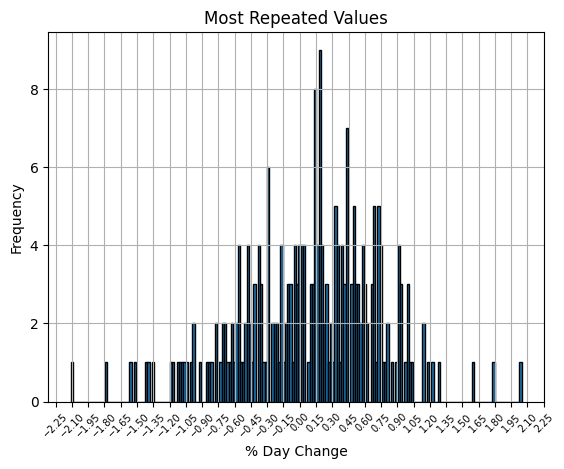

In [65]:
from matplotlib.ticker import MaxNLocator

(nifty.data.Day_Change*100).hist(bins=200, edgecolor='black')

# Add titles and labels
plt.title('Most Repeated Values')
plt.xlabel('% Day Change')
plt.ylabel('Frequency')
plt.xticks(rotation=45,size=7)

ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(MaxNLocator(nbins=40))

# Show the plot
plt.show()

In [41]:
data = yf.download('^NSEI',interval='1d',period='1y')

[*********************100%%**********************]  1 of 1 completed


In [42]:
data['Day_Change'] = np.log(data["Close"]/data['Close'].shift(1))

In [43]:
data

,Open,High,Low,Close,Adj Close,Volume,Day_Change
Date,,,,,,,
2023-05-22,18201.099609,18335.250000,18178.849609,18314.400391,18314.400391,262600,NaN
2023-05-23,18362.900391,18419.750000,18324.199219,18348.000000,18348.000000,270400,0.001833
2023-05-24,18294.800781,18392.599609,18262.949219,18285.400391,18285.400391,232600,-0.003418
2023-05-25,18268.900391,18338.099609,18202.400391,18321.150391,18321.150391,235900,0.001953
2023-05-26,18368.349609,18508.550781,18333.150391,18499.349609,18499.349609,198700,0.009679
...,...,...,...,...,...,...,...
2024-05-14,22112.900391,22270.050781,22081.250000,22217.849609,22217.849609,230200,0.005135
2024-05-15,22255.599609,22297.550781,22151.750000,22200.550781,22200.550781,231900,-0.000779
2024-05-16,22319.199219,22432.250000,22054.550781,22403.849609,22403.849609,368900,0.009116


In [50]:
closes = list(data.Day_Change)

In [52]:
closes.pop()

0.002798133238882937

In [57]:
dd = pd.DataFrame(closes)

In [60]:
dd.std()*math.sqrt(len(dd))

0    0.099685
dtype: float64